256


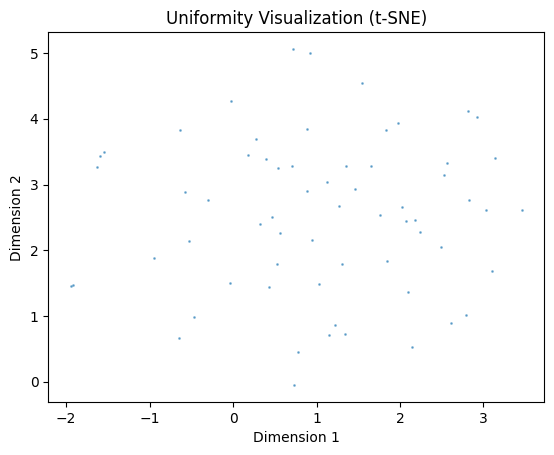

In [11]:
from tqdm import tqdm
import random
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import torch.nn as nn

input_file = 'data/wiki1m_for_simcse.txt'
with open(input_file, 'r', encoding='utf-8') as f:
    sent_list = f.read().splitlines()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'princeton-nlp/unsup-simcse-bert-base-uncased'
# model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

bs = 64

list1 = sent_list[:bs]
list2 = random.sample(sent_list, bs)

sent_list = list1 * 2 + list2 * 2   # list1 list1 list2 list2

print(len(sent_list))

inputs = tokenizer(sent_list, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(**inputs.to(device))

last_hidden_states = outputs.last_hidden_state  # (bs*4, seq_len, hidden_size)

pooler_output = outputs.pooler_output  # (bs*4, hidden_size)
pooler_output = pooler_output.view (4, bs, -1)  # (4, bs, hidden_size)

z1 ,z2 ,z3, z4 = pooler_output

class Similarity(nn.Module):

    def __init__(self, temp):
        super().__init__()
        self.temp = temp
        self.cos = nn.CosineSimilarity(dim=-1)

    def forward(self, x, y):
        return self.cos(x, y) / self.temp

# sim = Similarity(1)

# cos_sim_12 = sim(z1.unsqueeze(1), z2.unsqueeze(0))

# 打印相似度
# print(cos_sim_12)

# cos_sim_34 = sim(z3.unsqueeze(1), z4.unsqueeze(0))

# loss_fct = nn.CrossEntropyLoss()

# labels = torch.arange(cos_sim_12.size(0)).long().to(device)

# loss1 = loss_fct(cos_sim_12, labels)
# loss2 = loss_fct(cos_sim_34, labels)

# print(loss1, loss2)


from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# 对Z1可视化
# 使用 t-SNE 降维
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(z3.cpu().numpy())

# 绘制散点图
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=1, alpha=0.5)
plt.title('Uniformity Visualization (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

